<h1> K Nearest Neighborhood
    

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import numpy as np
import pandas as pd
import time

In [2]:
class CF():
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        ## define user-user CF if uuCF =1 or item-item CF otherwise
        self.uuCF = uuCF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    # normalize rating -1 to 1
    def normalize_Y(self):
        users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users, ))
        
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            
            #take mean
            m = np.nanmean(ratings)
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            
            #normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]
            
        ## store nonzeros
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()
        
    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T)
    
    def refresh(self):
        self.normalize_Y()
        self.similarity()
        
    def fit(self):
        self.refresh()
    
    def __pred(self, u, i, normalized = 1):
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
    
    def recommend(self, u, perUser = 1, countItem = 0):
        if perUser == 1:
            u-=1
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append((i+1, rating))
        if countItem > 0:
            return list(zip(*sorted(recommended_items, key=lambda data: data[1], reverse=True)[:countItem]))[0]
        return recommended_items
    
    def print_recommendation(self):
        print('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u, perUser=0)
            if self.uuCF:
                print('    Recommend item(s):', recommended_items, 'for user', u + 1)
            else: 
                print('    Recommend item', u + 1, 'for user(s) : ', recommended_items)      
        # Calculate RMSE
    def rmse(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0 # squared error
        for n in range(n_tests):
            if self.uuCF:
                SE += (self.__pred(rate_test[n, 0], rate_test[n, 1], normalized = 0) - rate_test[n, 2])**2 
            else:
                SE += (self.__pred(rate_test[n, 1], rate_test[n, 0], normalized = 0) - rate_test[n, 2])**2
        return np.sqrt(SE/n_tests)

In [3]:
from utils import *
all_train, rate_train, rate_valid, rate_test = split_dataset()

# indices start from 0
all_train[:, :2] -= 1
rate_valid[:, :2] -=1
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


Calculate RMSE with k = 30, user_Knn

In [4]:
rs = CF(all_train, k = 30, uuCF = 1)
rs.fit()
rs.rmse(rate_test)

0.9587480580770331

Calculate RMSE with k = 30, item_Knn

In [5]:
rs = CF(all_train, k = 30, uuCF = 0)
rs.fit()
rs.rmse(rate_test)

C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.9537821911421

In [6]:
rs.recommend(1,countItem=10)

(507, 850, 849, 810, 811, 939, 152, 118, 513, 477)

In [8]:
rmse_result = dict({"k": [], "User_kNN_RMSE": [], "Item_kNN_RMSE": []})
for n in range(5, 100, 5):
    rs_user = CF(rate_train, k = n, uuCF = 1)
    rs_user.fit()
    res_user = rs_user.rmse(rate_valid)
    rs_item = CF(rate_train, k = n, uuCF = 0)
    rs_item.fit()
    res_item = rs_item.rmse(rate_test)
    rmse_result["k"].append(n)
    rmse_result["User_kNN_RMSE"].append(res_user)
    rmse_result["Item_kNN_RMSE"].append(res_item)

<AxesSubplot:xlabel='k'>

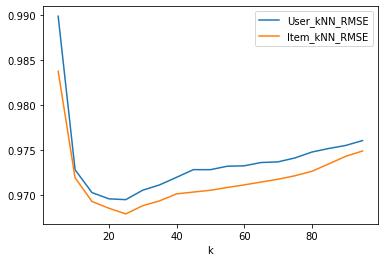

In [13]:
import matplotlib.pyplot as plt

rmse_result = pd.DataFrame(rmse_result)
rmse_result.set_index("k")

rmse_result.plot.line(x="k")

In [14]:
rmse_result.head(20)

,k,User_kNN_RMSE,Item_kNN_RMSE
0,5,0.989842,0.983738
1,10,0.972811,0.971920
2,15,0.970277,0.969290
3,20,0.969584,0.968541
4,25,0.969495,0.967912
5,30,0.970541,0.968824
6,35,0.971132,0.969361
7,40,0.971973,0.970135
8,45,0.972824,0.970337
9,50,0.972819,0.970533


<h2> Best value k for 2 model is 25

<h3> User_kNN

In [15]:
rs = CF(all_train, k = 25, uuCF = 1)
rs.fit()
rs.rmse(rate_test)

0.9588561341420486

<h3>Item_kNN

In [16]:
rs = CF(all_train, k = 25, uuCF = 0)
rs.fit()
rs.rmse(rate_test)

C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.9539008698118429